In [3]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import pandas as pd

import lightgbm as lg
from sklearn.ensemble import RandomForestClassifier

from score_function import get_scores
from ensemble_model import EnsembleModel

In [5]:
PATH = '../train/'

In [6]:
labels = pd.read_csv(PATH+'labels_train.csv', header=None)
gsr_train = pd.read_csv(PATH+'gsr_train.csv', header=None)
rr_train = pd.read_csv(PATH+'rr_train.csv', header=None)
temp_train = pd.read_csv(PATH+'temp_train.csv', header=None)
hr_train = pd.read_csv(PATH+'hr_train.csv', header=None)

<AxesSubplot:>

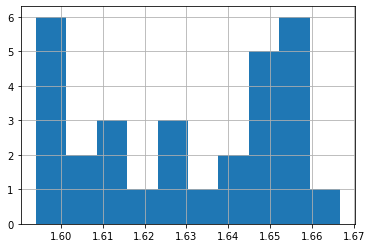

In [7]:
gsr_train.iloc[0].hist()

In [8]:
data_orig = pd.concat([rr_train, hr_train, temp_train, gsr_train], axis=1, sort=False)

In [9]:
rr_train.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.995520,0.984459,0.956805,0.934683,0.929152,0.945744,0.967867,0.978928,0.967867,0.956805,...,0.984459,0.989989,0.978928,0.962336,0.907029,0.851723,0.829600,0.857253,0.901499,0.929152
1,0.718987,0.768763,0.735579,0.779824,0.857253,0.940213,0.945744,0.851723,0.763232,0.741109,...,0.868315,0.818539,0.813008,0.818539,0.846192,0.857253,0.790885,0.785355,0.813008,0.851723
2,0.237819,0.199104,0.530944,0.956805,1.227808,1.106133,0.884907,0.829600,0.757701,0.829600,...,0.940213,0.923621,0.956805,1.012112,1.050827,1.111664,1.144848,1.172501,1.211216,1.117195
3,0.818539,0.818539,0.813008,0.807477,0.796416,0.785355,0.774293,0.763232,0.752171,0.752171,...,0.818539,0.829600,0.796416,0.807477,0.824069,0.846192,0.857253,0.840661,0.829600,0.801947
4,0.680272,0.790885,0.779824,0.785355,0.835131,0.779824,0.790885,0.741109,0.785355,0.757701,...,0.807477,0.790885,0.713456,0.575189,0.486699,0.326309,0.381616,0.387147,0.680272,0.796416


In [10]:
def fe(df,num):
    '''
    feature engineering step
    '''
    df.columns = [str(num)+'_'+str(i) for i in range(30)]
    df[f'x_{num}_min'] = df.min(1)
    df[f'x_{num}_max'] = df.max(1)
    df[f'x_{num}_med'] = df.median(1)
    df[f'x_{num}_std'] = df.std(1)
    df[f'x_{num}_sum'] = df.sum(1)
    df[f'x_{num}_ske'] = df.skew(1)
    df[f'x_{num}_mea'] = df.mean(1)

    
for nnn, i_df in enumerate([gsr_train, rr_train, temp_train, hr_train]):#temp_train
    i_df = fe(i_df, nnn)

In [11]:
data_fe = pd.concat([rr_train, gsr_train, temp_train, hr_train], axis=1, sort=False)

In [12]:
data_fe_only = data_fe[[i for i in data_fe.columns if 'x'==str(i)[:1]]]
data_fe_only.head()

,x_1_min,x_1_max,x_1_med,x_1_std,x_1_sum,x_1_ske,x_1_mea,x_0_min,x_0_max,x_0_med,...,x_2_sum,x_2_ske,x_2_mea,x_3_min,x_3_max,x_3_med,x_3_std,x_3_sum,x_3_ske,x_3_mea
0,0.829600,0.995520,0.951275,0.044262,31.093424,5.906969,1.891495,1.594050,1.666707,1.633575,...,1109.623170,5.906748,61.809808,60.000000,66.000000,62.000000,1.572397,2064.905730,5.907036,114.881069
1,0.718987,0.945744,0.788120,0.066242,26.643861,5.906244,1.644277,0.363995,0.673100,0.655739,...,1131.570030,5.906745,63.029078,71.666667,80.000000,74.666667,2.528915,2476.862249,5.907046,137.767543
2,0.199104,1.227808,0.956805,0.265537,30.368955,5.886244,1.850671,0.938108,1.048219,1.039323,...,1057.769320,5.906751,58.929039,58.333333,63.666667,63.000000,1.484346,2061.484346,5.907030,114.690992
3,0.746640,0.857253,0.790885,0.032689,26.242518,5.907017,1.622001,1.449977,1.618148,1.504966,...,1155.063725,5.906747,64.334283,71.666667,77.333333,75.666667,1.346369,2490.013036,5.906992,138.498141
4,0.326309,0.835131,0.745257,0.145604,23.093723,5.897229,1.446797,0.374815,0.382754,0.377606,...,1052.699987,5.906745,58.647409,52.000000,77.666667,76.166667,8.382676,2408.882676,5.904851,133.990839


In [18]:
data_norm = (data_fe_only - data_fe_only.mean())/data_fe_only.std()
data_norm.head()

,x_1_min,x_1_max,x_1_med,x_1_std,x_1_sum,x_1_ske,x_1_mea,x_0_min,x_0_max,x_0_med,...,x_2_sum,x_2_ske,x_2_mea,x_3_min,x_3_max,x_3_med,x_3_std,x_3_sum,x_3_ske,x_3_mea
0,1.329176,0.326136,1.208351,-0.851389,1.203617,0.676415,1.203945,-0.141864,-0.176330,-0.158718,...,0.719125,-0.472852,0.719125,-0.972918,-1.171580,-1.167050,-0.637304,-1.150402,0.271425,-1.150402
1,0.580328,-0.012626,-0.179384,-0.391378,0.009243,0.495913,0.009510,-0.831263,-0.719777,-0.701432,...,1.216065,-0.917371,1.216065,0.121822,0.011184,-0.023277,-0.220099,-0.002567,0.280787,-0.002566
2,-2.939258,1.907026,1.255393,3.779523,1.009152,-4.483171,1.006704,-0.509495,-0.514609,-0.488537,...,-0.454994,-0.025016,-0.454994,-1.129309,-1.368707,-1.076752,-0.675709,-1.159935,0.265449,-1.159935
3,0.767540,-0.614870,-0.155863,-1.093589,-0.098487,0.688355,-0.098113,-0.222611,-0.202889,-0.230097,...,1.748029,-0.587528,1.748029,0.121822,-0.214104,0.067021,-0.735891,0.034075,0.227424,0.034076
4,-2.078083,-0.765431,-0.543959,1.269536,-0.943702,-1.748370,-0.944616,-0.825199,-0.878581,-0.855800,...,-0.569779,-0.917371,-0.569779,-1.723596,-0.185943,0.112170,2.333141,-0.191978,-1.912676,-0.191981


In [36]:
model = EnsembleModel(n_models=7, num_boost_round=55)
get_scores(model, data_norm.values, labels[0].values, lg=True)

ACC: 0.628162689227841 0.03316473758098402
AUC: 0.6833713909950596 0.03631043618540608




(0.628162689227841,
 0.03316473758098402,
 0.6833713909950596,
 0.03631043618540608)